# Principal Component Analysis (PCA) vs. Independent Component Analysis (ICA): Illustrative Examples

This notebook demonstrates various practical examples of PCA and ICA for dimensionality reduction and source separation using simulated data.

In [63]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import warnings

# Set random seed for reproducibility
np.random.seed(9)
random_state = 9
# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Suppress warnings
warnings.filterwarnings('ignore')

## Example 1: PCA – Variance-Driven Dimension Reduction

We'll create a 2D dataset with two correlated Gaussian variables (forming a rotated ellipse shape) and apply PCA to find the principal directions. This will visually demonstrate how PCA aligns with the direction of maximal variance.

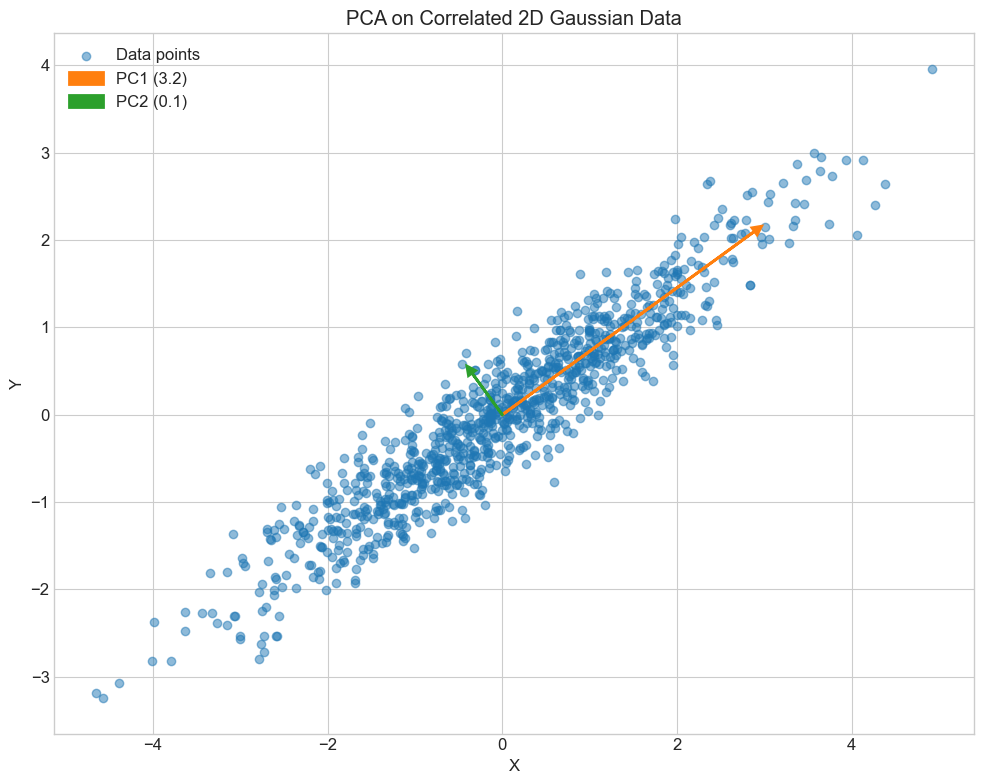

Explained variance ratio: [0.97348757 0.02651243]
Total explained variance: 1.00


In [64]:
# Generate correlated 2D Gaussian data
n_samples = 1000
mean = [0, 0]
cov = [[2.0, 1.5], [1.5, 1.0]]  # Covariance matrix with correlation
data = np.random.multivariate_normal(mean, cov, n_samples)

# Apply PCA
pca = PCA(n_components=2)
pca.fit(data)
transformed_data = pca.transform(data)

# Get principal components and explained variance
components = pca.components_
explained_variance = pca.explained_variance_

# Visualize the data and principal components
plt.figure(figsize=(10, 8))

# Plot original data points
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Data points')

# Plot principal components as arrows
for i, (comp, var) in enumerate(zip(components, explained_variance)):
    comp_arrow = comp * np.sqrt(var) * 2  # Scale arrow by variance
    plt.arrow(0, 0, comp_arrow[0], comp_arrow[1], 
              head_width=0.1, head_length=0.1, fc=f'C{i+1}', ec=f'C{i+1}', linewidth=2,
              label=f'PC{i+1} ({var:.1f})')

plt.title('PCA on Correlated 2D Gaussian Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")

## Example 2: PCA – Signal Compression in Time Series

Here we'll simulate multiple time series with a shared underlying trend plus random noise, then apply PCA to show how the first principal component captures the common trend.

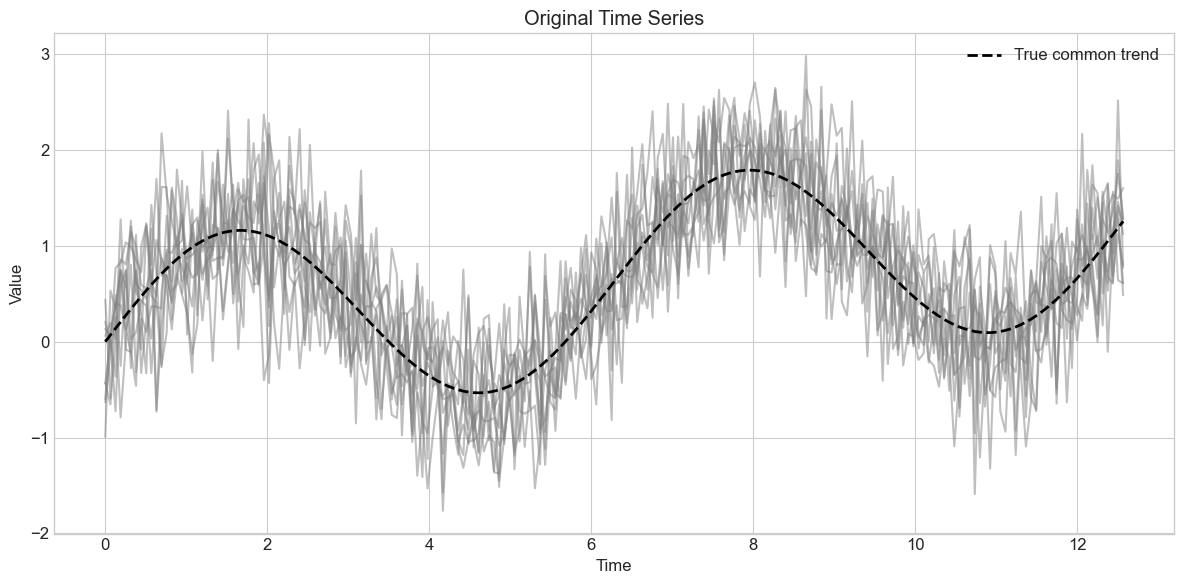

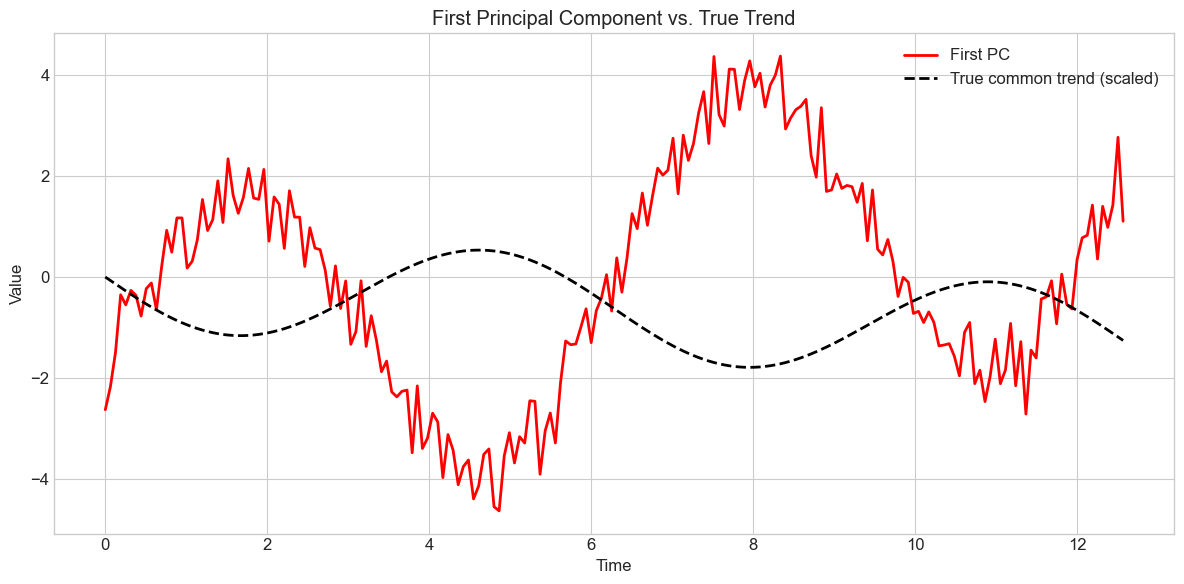

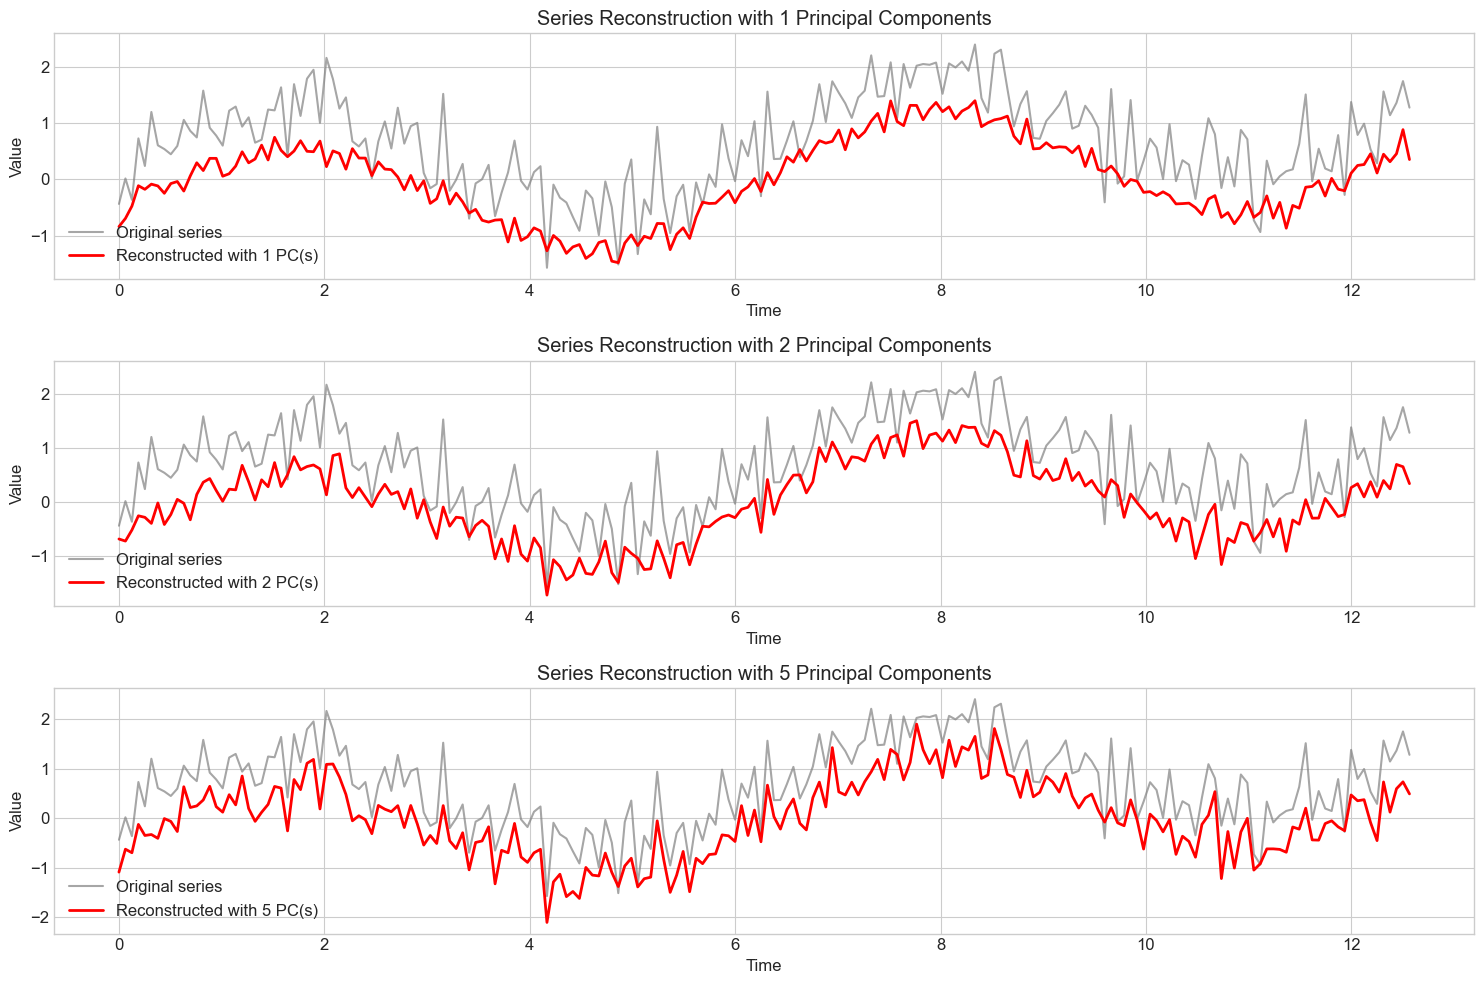

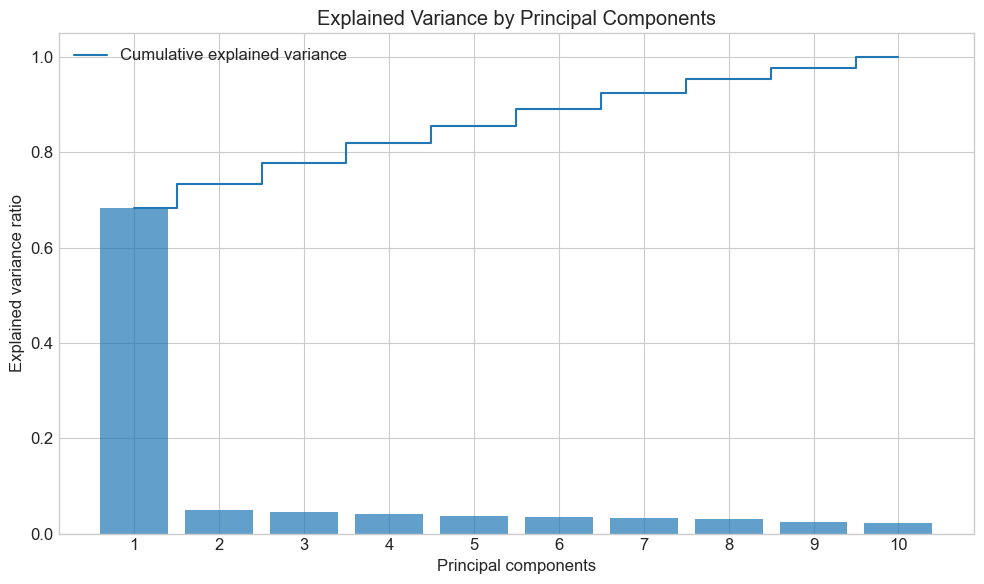

In [65]:
# Generate synthetic time series data
n_timepoints = 200
n_series = 10

# Create time points
t = np.linspace(0, 4*np.pi, n_timepoints)

# Create a common trend (a sine wave with drift)
common_trend = np.sin(t) + t/10

# Create multiple series with the common trend plus noise
noise_level = 0.5
data = np.zeros((n_timepoints, n_series))
for i in range(n_series):
    # Each series has the common trend plus random noise
    noise = np.random.normal(0, noise_level, n_timepoints)
    data[:, i] = common_trend + noise

# Apply PCA
pca = PCA()
components = pca.fit_transform(data)

# Visualize original time series
plt.figure(figsize=(12, 6))
for i in range(n_series):
    plt.plot(t, data[:, i], 'gray', alpha=0.5)
plt.plot(t, common_trend, 'k--', linewidth=2, label='True common trend')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# Visualize principal components
plt.figure(figsize=(12, 6))
plt.plot(t, components[:, 0], 'r-', linewidth=2, label='First PC')
plt.plot(t, -common_trend, 'k--', linewidth=2, label='True common trend (scaled)')
plt.title('First Principal Component vs. True Trend')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# Reconstruct data using top k components
k_values = [1, 2, 5]
plt.figure(figsize=(15, 10))

for i, k in enumerate(k_values):
    # Reconstruct using k components
    reconstructed = np.dot(components[:, :k], pca.components_[:k, :])
    
    # Plot original and reconstructed series for first time series
    plt.subplot(len(k_values), 1, i+1)
    plt.plot(t, data[:, 0], 'gray', label='Original series', alpha=0.7)
    plt.plot(t, reconstructed[:, 0], 'r-', linewidth=2, label=f'Reconstructed with {k} PC(s)')
    plt.title(f'Series Reconstruction with {k} Principal Components')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), pca.explained_variance_ratio_[:10], alpha=0.7, align='center')
plt.step(range(1, 11), np.cumsum(pca.explained_variance_ratio_[:10]), where='mid', label='Cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, 11))
plt.legend()
plt.tight_layout()
plt.show()

## Example 3: ICA – Cocktail Party Problem (Classic)

We'll simulate the classic cocktail party problem by creating and mixing synthetic source signals, then using ICA to recover the original sources. Separating out the mixed signals will illustrate how ICA can identify independent components even when they are mixed together.

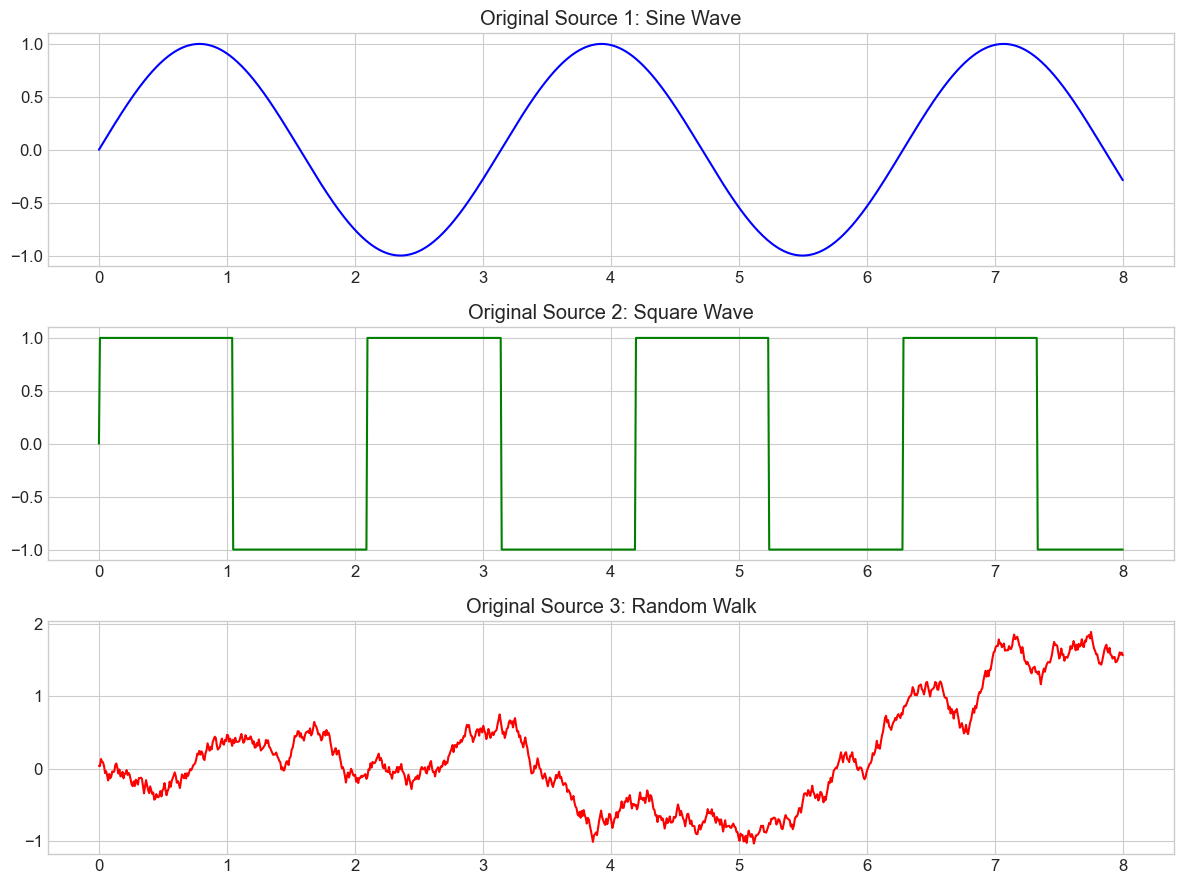

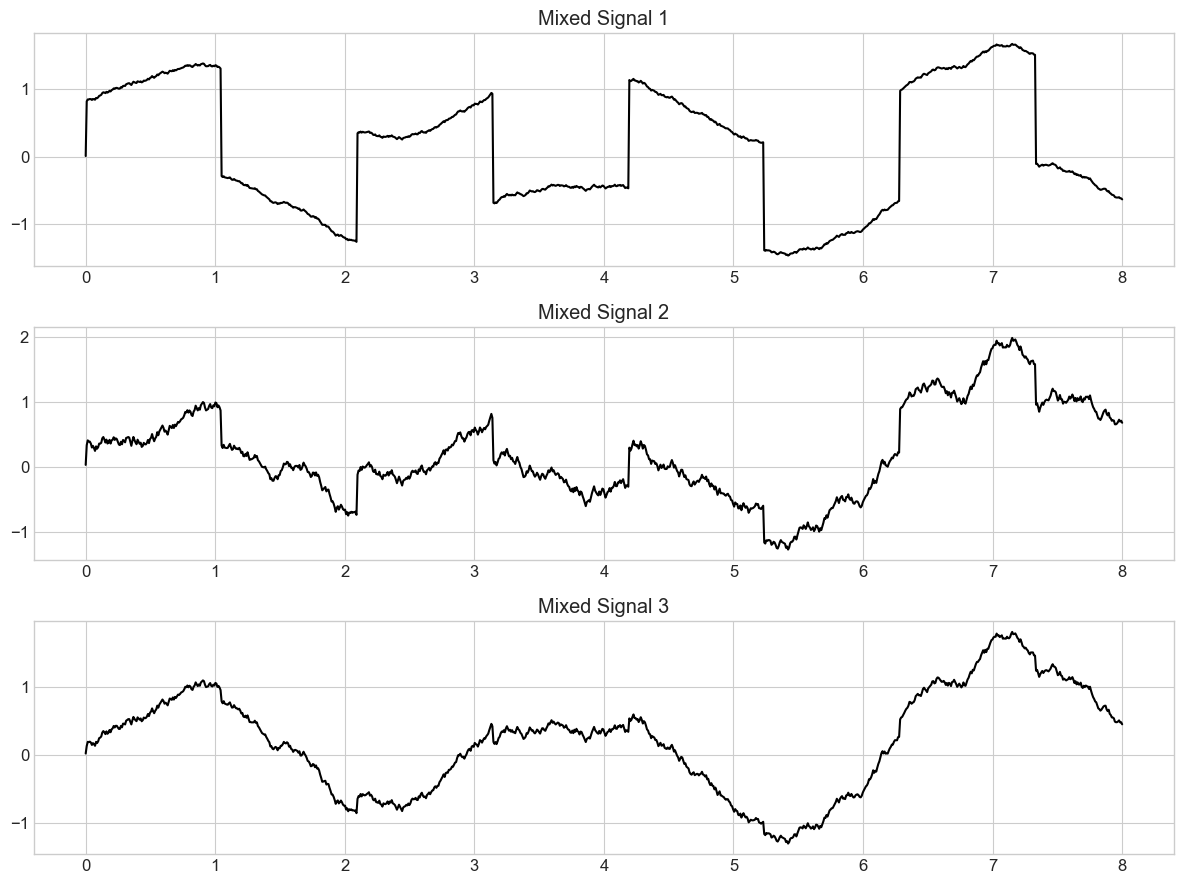

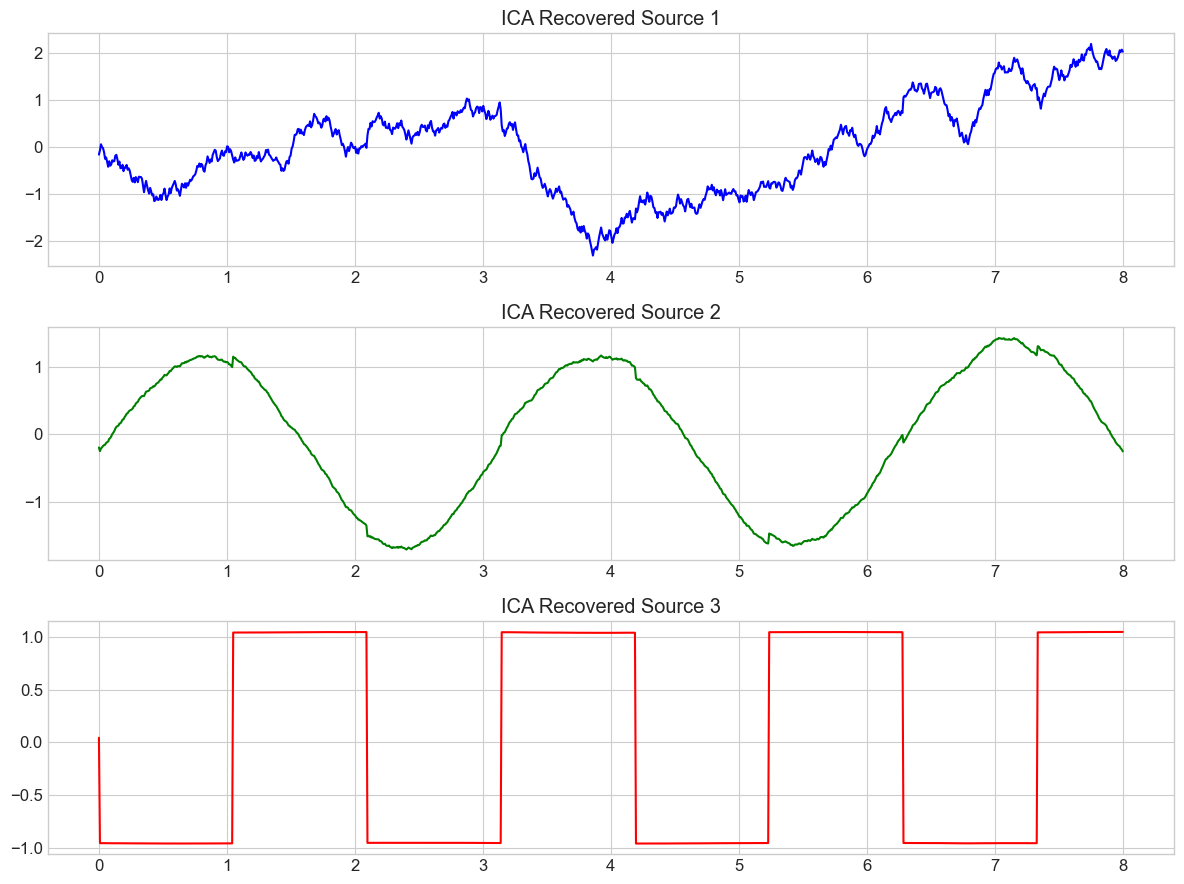

Note: ICA typically recovers the original sources but with arbitrary scaling and sign.
This kind of signal separation becomes useful in any setting where overlapping influences need to be disentangled.


In [66]:
# Define a sample size
n_samples = 1000

# Create time array
time = np.linspace(0, 8, n_samples)

# Create three different source signals
s1 = np.sin(2 * time)  # Sine wave
s2 = np.sign(np.sin(3 * time))  # Square wave
s3 = np.random.uniform(-1, 1, size=time.shape)  # White noise (uniform)
s3 = np.cumsum(s3) * 0.1  # Random walk to make it more interesting

# Combine signals into a matrix
S = np.c_[s1, s2, s3]

# Create a mixing matrix
A = np.array([[0.5, 0.8, 0.2],
              [0.4, 0.3, 0.7],
              [0.8, 0.1, 0.5]])

# Mix the sources to create the observed signals
X = np.dot(S, A.T)

# Apply ICA using a pipeline with scaling
ica_pipe = make_pipeline(StandardScaler(), FastICA(n_components=3, random_state=random_state))
S_ica = ica_pipe.fit_transform(X)

# Plot original sources
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.plot(time, s1, 'b')
plt.title('Original Source 1: Sine Wave')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, s2, 'g')
plt.title('Original Source 2: Square Wave')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, s3, 'r')
plt.title('Original Source 3: Random Walk')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mixed signals
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.plot(time, X[:, 0], 'k')
plt.title('Mixed Signal 1')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, X[:, 1], 'k')
plt.title('Mixed Signal 2')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, X[:, 2], 'k')
plt.title('Mixed Signal 3')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot recovered sources (ICA components)
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.plot(time, S_ica[:, 0], 'b')
plt.title('ICA Recovered Source 1')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, S_ica[:, 1], 'g')
plt.title('ICA Recovered Source 2')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, S_ica[:, 2], 'r')
plt.title('ICA Recovered Source 3')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Note: ICA typically recovers the original sources but with arbitrary scaling and sign.")
print("This kind of signal separation becomes useful in any setting where overlapping influences need to be disentangled.")

## Example 4: ICA – Non-Gaussianity Detection

This example demonstrates how ICA leverages non-Gaussianity to separate mixed signals from different distributions.

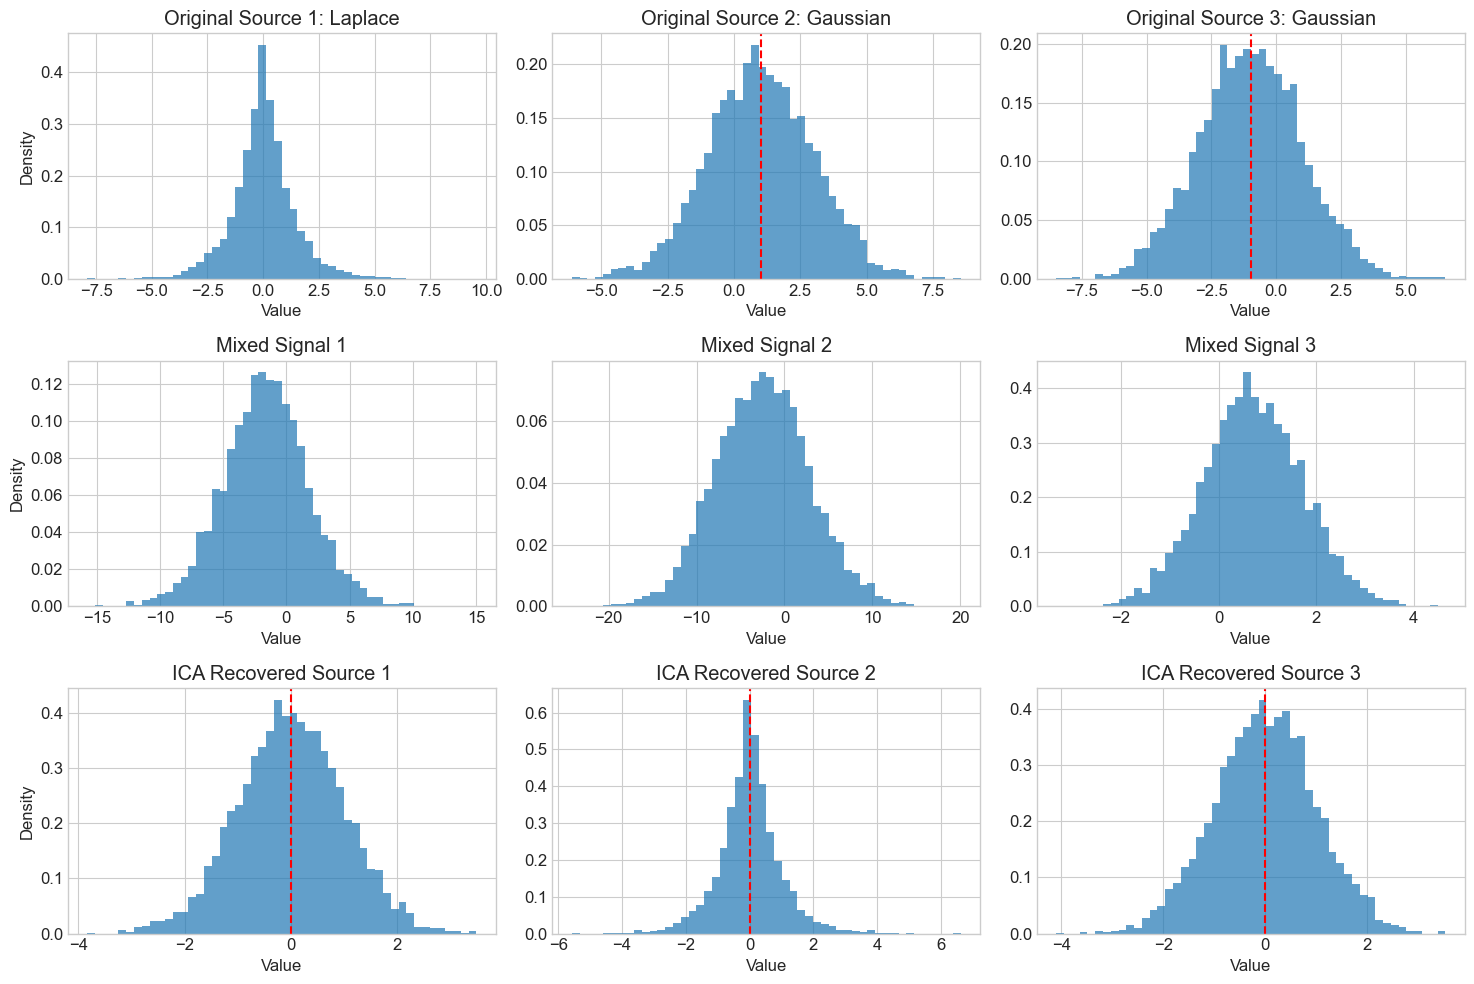

With two Gaussian sources, ICA can no longer fully separate the original signals. Notice how the mean of the Gaussian sources is not preserved.
It may still recover the non-Gaussian source (Laplace), but the Gaussian components remain entangled.


In [67]:
# Create sample size
n_samples = 5000

# === Generate source signals from different distributions ===
# ICA relies on non-Gaussianity for separation.
# Here we intentionally include two Gaussian sources to highlight ICA's limitations.
s1 = np.random.laplace(0, 1, n_samples)    # Laplace distribution (non-Gaussian)
s2 = np.random.normal(1, 2, n_samples)     # Gaussian
s3 = np.random.normal(-1, 2, n_samples)     # Another Gaussian

# Combine the independent signals into a single matrix (rows = samples, columns = sources)
S = np.c_[s1, s2, s3]

# === Create a random mixing matrix ===
# This simulates how real-world sensors receive mixtures of the original sources
A = np.random.randn(3, 3)

# === Mix the source signals ===
# The observed signals (X) are linear combinations of the original sources
X = np.dot(S, A.T)

# === Apply ICA ===
# ICA attempts to recover the original sources from the mixed signals.
# It works best when the sources are non-Gaussian and statistically independent.
ica_pipe = make_pipeline( FastICA(n_components=3, random_state=42))
S_ica = ica_pipe.fit_transform(X)

# === Plotting section ===
plt.figure(figsize=(15, 10))

# --- Original Source Distributions ---
# Expect a sharp-peaked Laplace and two smooth Gaussian curves.
plt.subplot(3, 3, 1)
plt.hist(s1, bins=50, density=True, alpha=0.7)
plt.title('Original Source 1: Laplace')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(3, 3, 2)
plt.hist(s2, bins=50, density=True, alpha=0.7)
# Vertical line for Gaussian mean
plt.axvline(x=np.mean(s2), color='r', linestyle='--', label='Mean')
plt.title('Original Source 2: Gaussian')
plt.xlabel('Value')

plt.subplot(3, 3, 3)
plt.hist(s3, bins=50, density=True, alpha=0.7)
# Vertical line for Gaussian mean
plt.axvline(x=np.mean(s3), color='r', linestyle='--', label='Mean')
plt.title('Original Source 3: Gaussian')
plt.xlabel('Value')

# --- Mixed Signal Distributions ---
# These histograms show the distributions after mixing.
# They should all look fairly Gaussian due to the central limit theorem.
plt.subplot(3, 3, 4)
plt.hist(X[:, 0], bins=50, density=True, alpha=0.7)
plt.title('Mixed Signal 1')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(3, 3, 5)
plt.hist(X[:, 1], bins=50, density=True, alpha=0.7)
plt.title('Mixed Signal 2')
plt.xlabel('Value')

plt.subplot(3, 3, 6)
plt.hist(X[:, 2], bins=50, density=True, alpha=0.7)
plt.title('Mixed Signal 3')
plt.xlabel('Value')

# --- ICA Recovered Distributions ---
# ICA should recover the Laplace-like component reasonably well,
# but will likely fail to clearly separate both Gaussian components.
plt.subplot(3, 3, 7)
plt.hist(S_ica[:, 0], bins=50, density=True, alpha=0.7)
# Vertical line for Gaussian mean
plt.axvline(x=np.mean(S_ica[:, 0]), color='r', linestyle='--', label='Mean')
plt.title('ICA Recovered Source 1')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(3, 3, 8)
plt.hist(S_ica[:, 1], bins=50, density=True, alpha=0.7)
# Vertical line for Gaussian mean
plt.axvline(x=np.mean(S_ica[:, 1]), color='r', linestyle='--', label='Mean')
plt.title('ICA Recovered Source 2')
plt.xlabel('Value')

plt.subplot(3, 3, 9)
plt.hist(S_ica[:, 2], bins=50, density=True, alpha=0.7)
# Vertical line for Gaussian mean
plt.axvline(x=np.mean(S_ica[:, 2]), color='r', linestyle='--', label='Mean')
plt.title('ICA Recovered Source 3')
plt.xlabel('Value')

plt.tight_layout()
plt.show()

# Final note on interpretation
print("With two Gaussian sources, ICA can no longer fully separate the original signals. Notice how the mean of the Gaussian sources is not preserved.")
print("It may still recover the non-Gaussian source (Laplace), but the Gaussian components remain entangled.")

## Example 5: PCA vs ICA – Mixed Signals with Shared and Unique Patterns

We'll simulate a scenario with a slow oscillation, impulse signals, and Gaussian noise, then compare how PCA and ICA handle these different patterns.

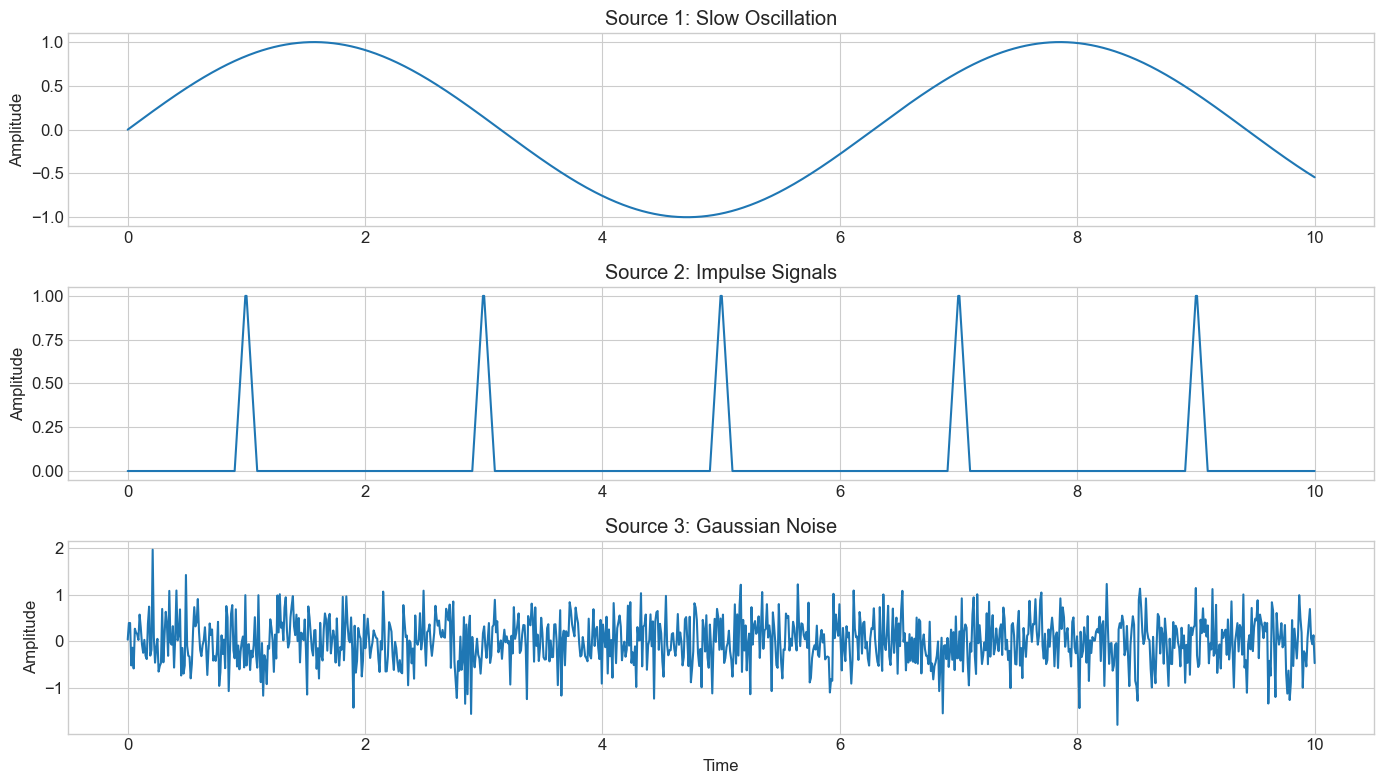

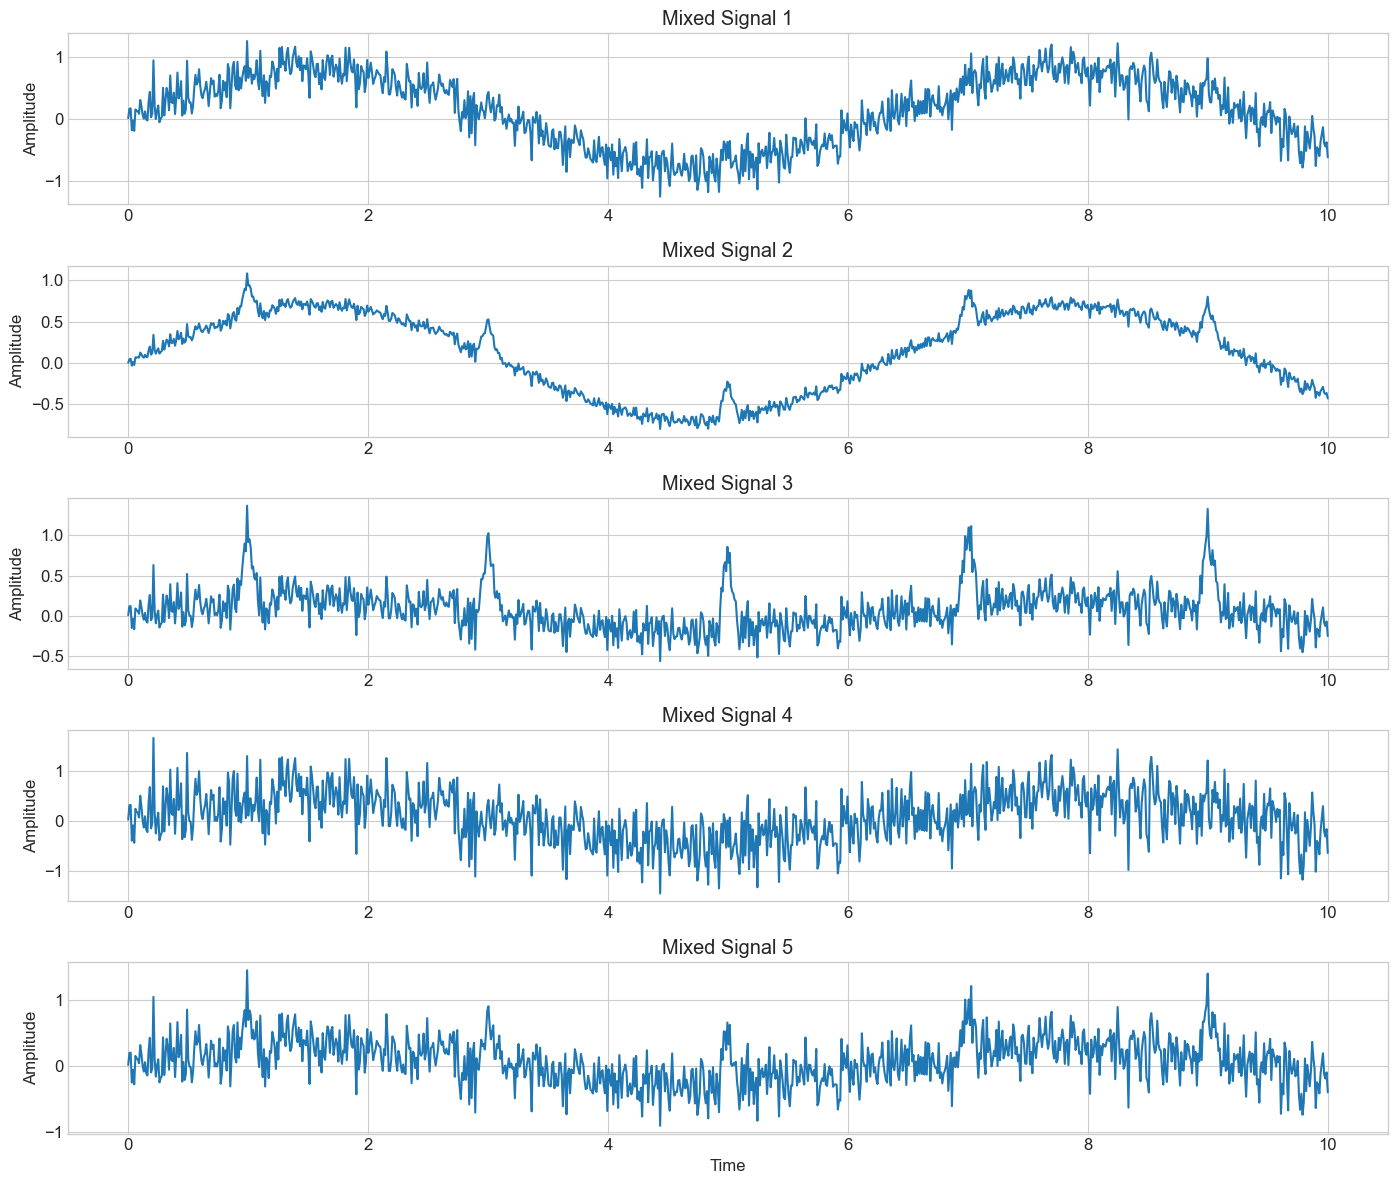

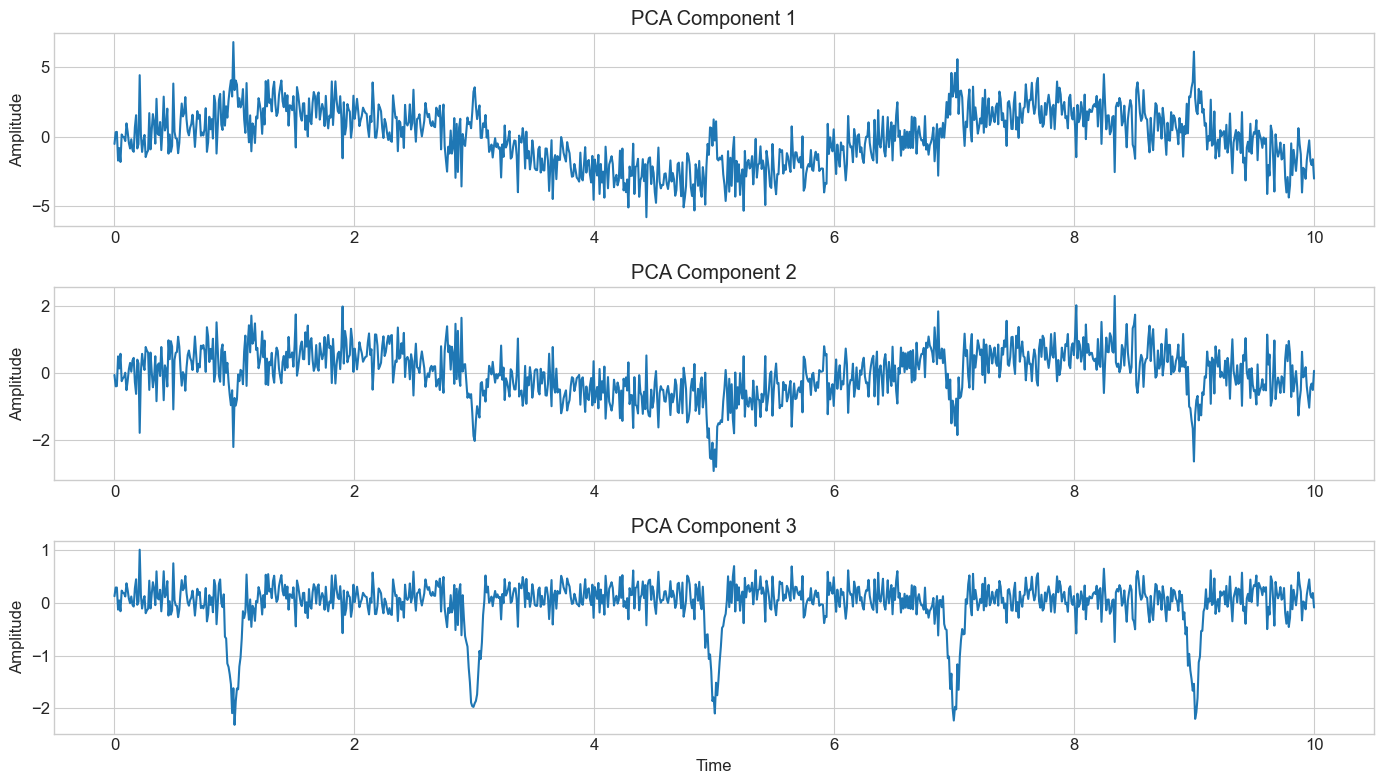

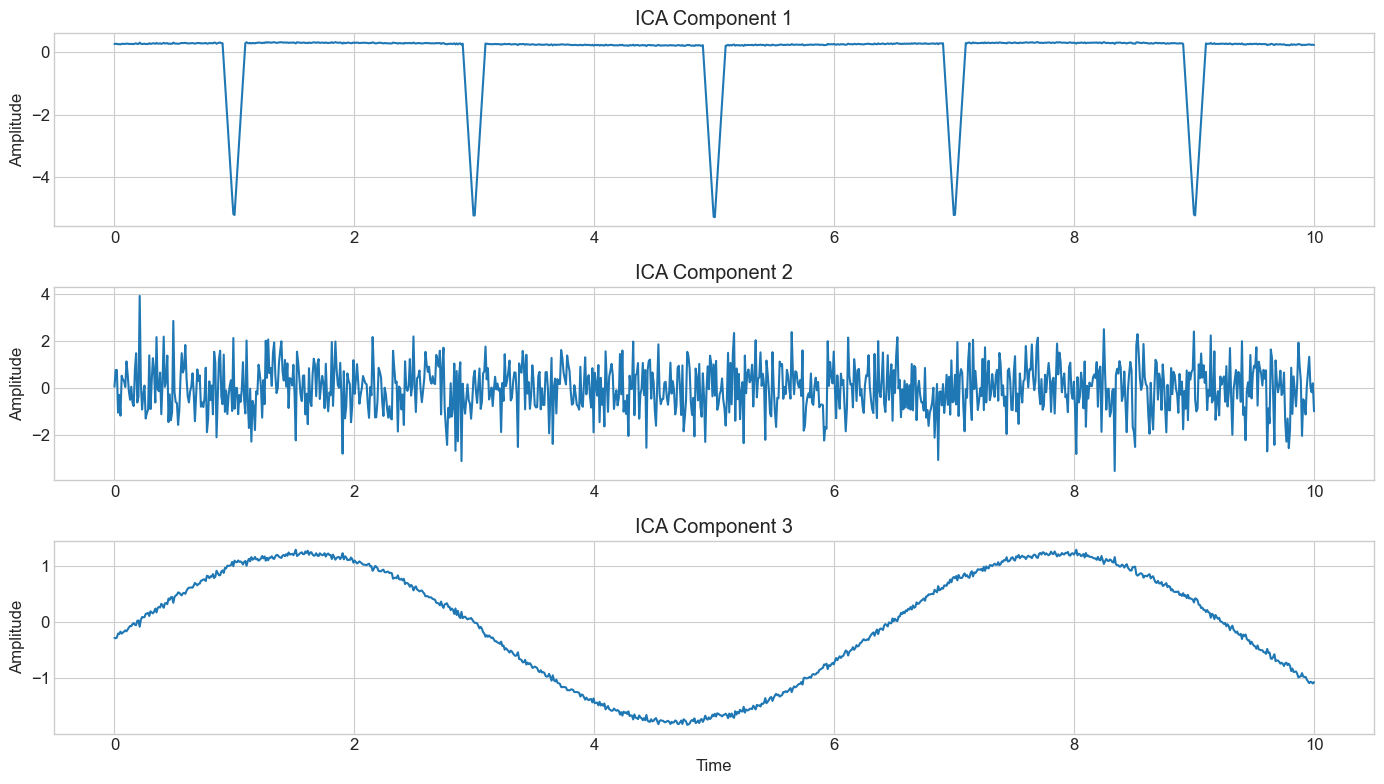

PCA Explained Variance Ratio: [0.85153799 0.10661551 0.0418465 ]

Observations:
1. PCA prioritizes components by variance, typically capturing the slow oscillation first.
2. ICA recovers components that are more similar to the original source signals.
3. ICA is better at isolating the impulse signals from the continuous signals.


In [68]:
# Set up time points
n_samples = 1000
time = np.linspace(0, 10, n_samples)

# Create three distinct source signals
# Signal 1: Slow oscillation (sine wave)
s1 = np.sin(time)

# Signal 2: Impulse signals at specific points
s2 = np.zeros_like(time)
impulse_locations = [100, 300, 500, 700, 900]
for loc in impulse_locations:
    s2[loc-10:loc+10] = np.concatenate([np.linspace(0, 1, 10), np.linspace(1, 0, 10)])

# Signal 3: Gaussian noise
s3 = np.random.normal(0, 0.5, n_samples)

# Combine signals
S_true = np.c_[s1, s2, s3]

# Create mixing matrix for 5 observed signals
A = np.array([
    [0.8, 0.2, 0.4],  # Mixed signal 1
    [0.7, 0.4, 0.1],  # Mixed signal 2
    [0.2, 0.9, 0.3],  # Mixed signal 3
    [0.5, 0.1, 0.8],  # Mixed signal 4
    [0.3, 0.7, 0.5]   # Mixed signal 5
])

# Create 5 mixed observed signals
X = np.dot(S_true, A.T)

# Plot the true source signals
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(time, s1)
plt.title('Source 1: Slow Oscillation')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, s2)
plt.title('Source 2: Impulse Signals')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, s3)
plt.title('Source 3: Gaussian Noise')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the mixed observed signals
plt.figure(figsize=(14, 12))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(time, X[:, i])
    plt.title(f'Mixed Signal {i+1}')
    plt.ylabel('Amplitude')
    plt.grid(True)
    if i == 4:  # Only add x-label for the last subplot
        plt.xlabel('Time')
plt.tight_layout()
plt.show()

# Apply PCA and ICA using pipelines
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=3))
ica_pipe = make_pipeline(StandardScaler(), FastICA(n_components=3, random_state=42))

S_pca = pca_pipe.fit_transform(X)
S_ica = ica_pipe.fit_transform(X)

# Plot PCA results
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(time, S_pca[:, 0])
plt.title('PCA Component 1')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, S_pca[:, 1])
plt.title('PCA Component 2')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, S_pca[:, 2])
plt.title('PCA Component 3')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot ICA results
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(time, S_ica[:, 0])
plt.title('ICA Component 1')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, S_ica[:, 1])
plt.title('ICA Component 2')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, S_ica[:, 2])
plt.title('ICA Component 3')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print insights
print("PCA Explained Variance Ratio:", pca_pipe.named_steps['pca'].explained_variance_ratio_)
print("\nObservations:")
print("1. PCA prioritizes components by variance, typically capturing the slow oscillation first.")
print("2. ICA recovers components that are more similar to the original source signals.")
print("3. ICA is better at isolating the impulse signals from the continuous signals.")

## Example 6: Event Study with PCA – Drift & Reversal Pattern Detection

We'll simulate an event study dataset with specific patterns (drift before event, reversal after) and use PCA to extract these components.

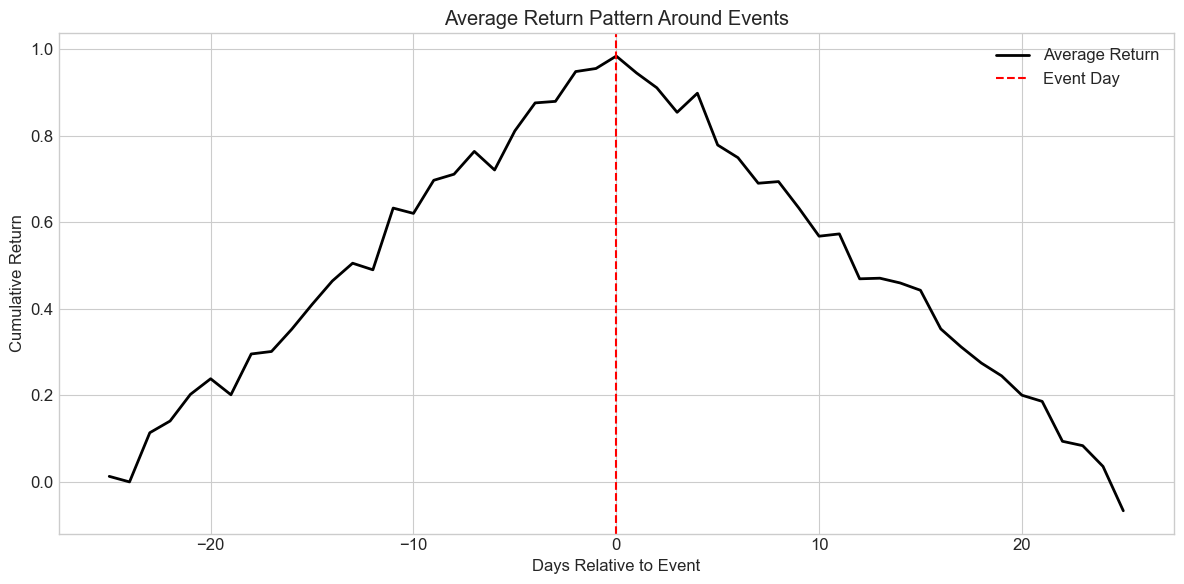

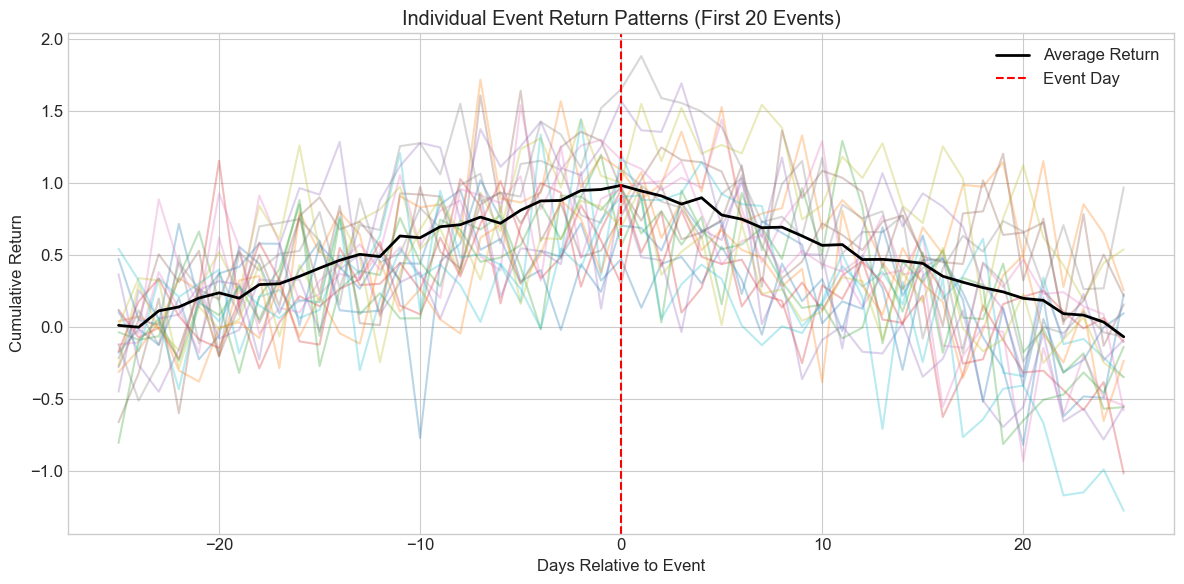

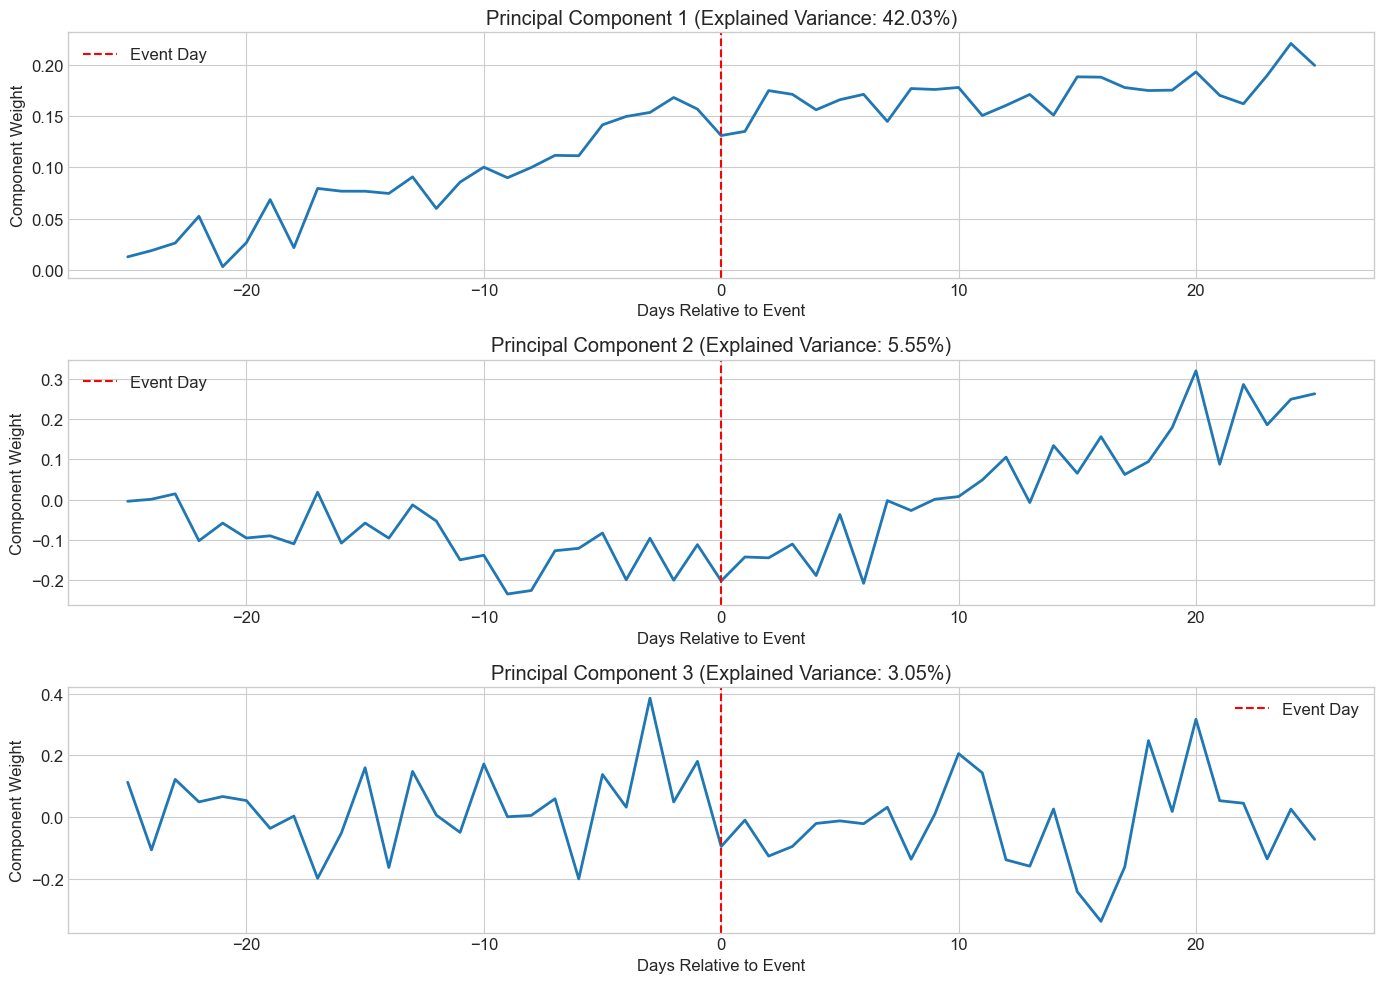

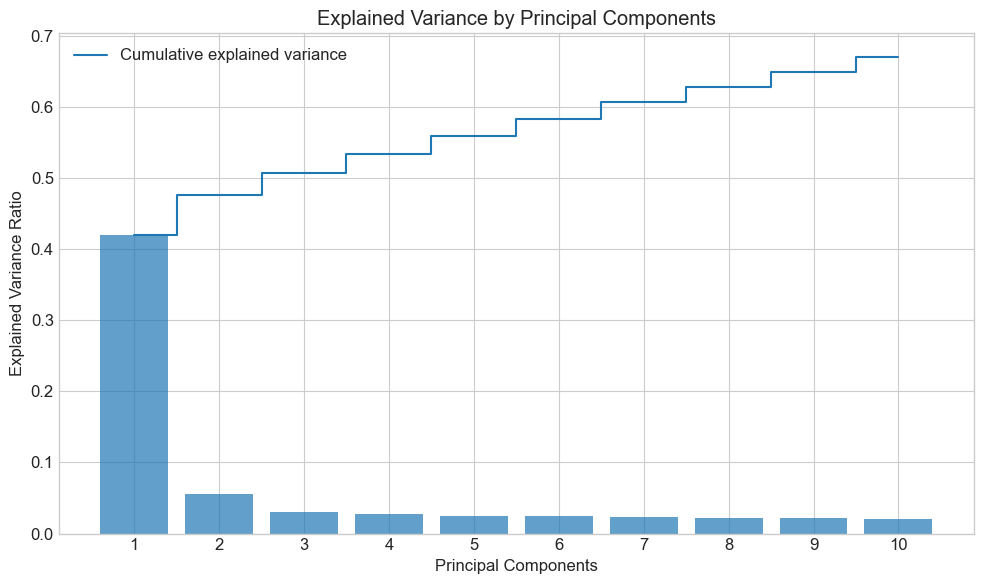

Insights from PCA in Event Studies:
1. PCA effectively identifies the dominant patterns in event-aligned returns.
2. The first component typically captures the most consistent feature across events.
3. Secondary components may reflect specific behaviors like reversal effects.
4. Top 3 components explain 50.63% of the total variance.


In [69]:
# Create an event study dataset
n_events = 100
n_days = 51  # -25 to +25 days around event
event_day_index = 25  # Index of the event day (day 0) in the array

# Time indices relative to event
time_indices = np.arange(-25, 26)

# Create patterns to inject
# Pattern 1: Gradual drift up before event, flat after
pattern1 = np.zeros(n_days)
pattern1[:event_day_index] = np.linspace(0, 1, event_day_index)  # Drift up before event
pattern1[event_day_index:] = 1  # Flat after event

# Pattern 2: No change before, sharp reversal after
pattern2 = np.zeros(n_days)
pattern2[event_day_index:] = np.linspace(0, -1, n_days - event_day_index)  # Reversal after event

# Initialize event-aligned return matrix
event_returns = np.zeros((n_events, n_days))

# Generate event data with patterns and noise
for i in range(n_events):
    # Randomly weight the two patterns
    w1 = np.random.uniform(0.5, 1.5)
    w2 = np.random.uniform(0.5, 1.5)
    
    # Add weighted patterns and noise
    noise = np.random.normal(0, 0.3, n_days)  # Random noise
    event_returns[i, :] = w1 * pattern1 + w2 * pattern2 + noise

# Apply PCA to extract components
pca = PCA()
pca.fit(event_returns)
components = pca.components_
explained_var = pca.explained_variance_ratio_

# Create DataFrame for event returns
event_df = pd.DataFrame(event_returns, columns=time_indices)

# Plot average event return pattern
plt.figure(figsize=(12, 6))
plt.plot(time_indices, event_df.mean(), 'k-', linewidth=2, label='Average Return')
plt.axvline(x=0, color='r', linestyle='--', label='Event Day')
plt.title('Average Return Pattern Around Events')
plt.xlabel('Days Relative to Event')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot individual event patterns
plt.figure(figsize=(12, 6))
for i in range(20):  # Plot first 20 events
    plt.plot(time_indices, event_returns[i], alpha=0.3)
plt.plot(time_indices, event_df.mean(), 'k-', linewidth=2, label='Average Return')
plt.axvline(x=0, color='r', linestyle='--', label='Event Day')
plt.title('Individual Event Return Patterns (First 20 Events)')
plt.xlabel('Days Relative to Event')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the first 3 principal components
plt.figure(figsize=(14, 10))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(time_indices, components[i], linewidth=2)
    plt.axvline(x=0, color='r', linestyle='--', label='Event Day')
    plt.title(f'Principal Component {i+1} (Explained Variance: {explained_var[i]:.2%})')
    plt.xlabel('Days Relative to Event')
    plt.ylabel('Component Weight')
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

# Plot scree plot for explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), explained_var[:10], alpha=0.7, align='center')
plt.step(range(1, 11), np.cumsum(explained_var[:10]), where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, 11))
plt.legend()
plt.tight_layout()
plt.show()

print("Insights from PCA in Event Studies:")
print("1. PCA effectively identifies the dominant patterns in event-aligned returns.")
print("2. The first component typically captures the most consistent feature across events.")
print("3. Secondary components may reflect specific behaviors like reversal effects.")
print(f"4. Top 3 components explain {np.sum(explained_var[:3]):.2%} of the total variance.")

## Example 7: Sensitivity of ICA to Initialization and Parameters

This example demonstrates how ICA results can vary with different initializations, random seeds, and algorithm parameters.

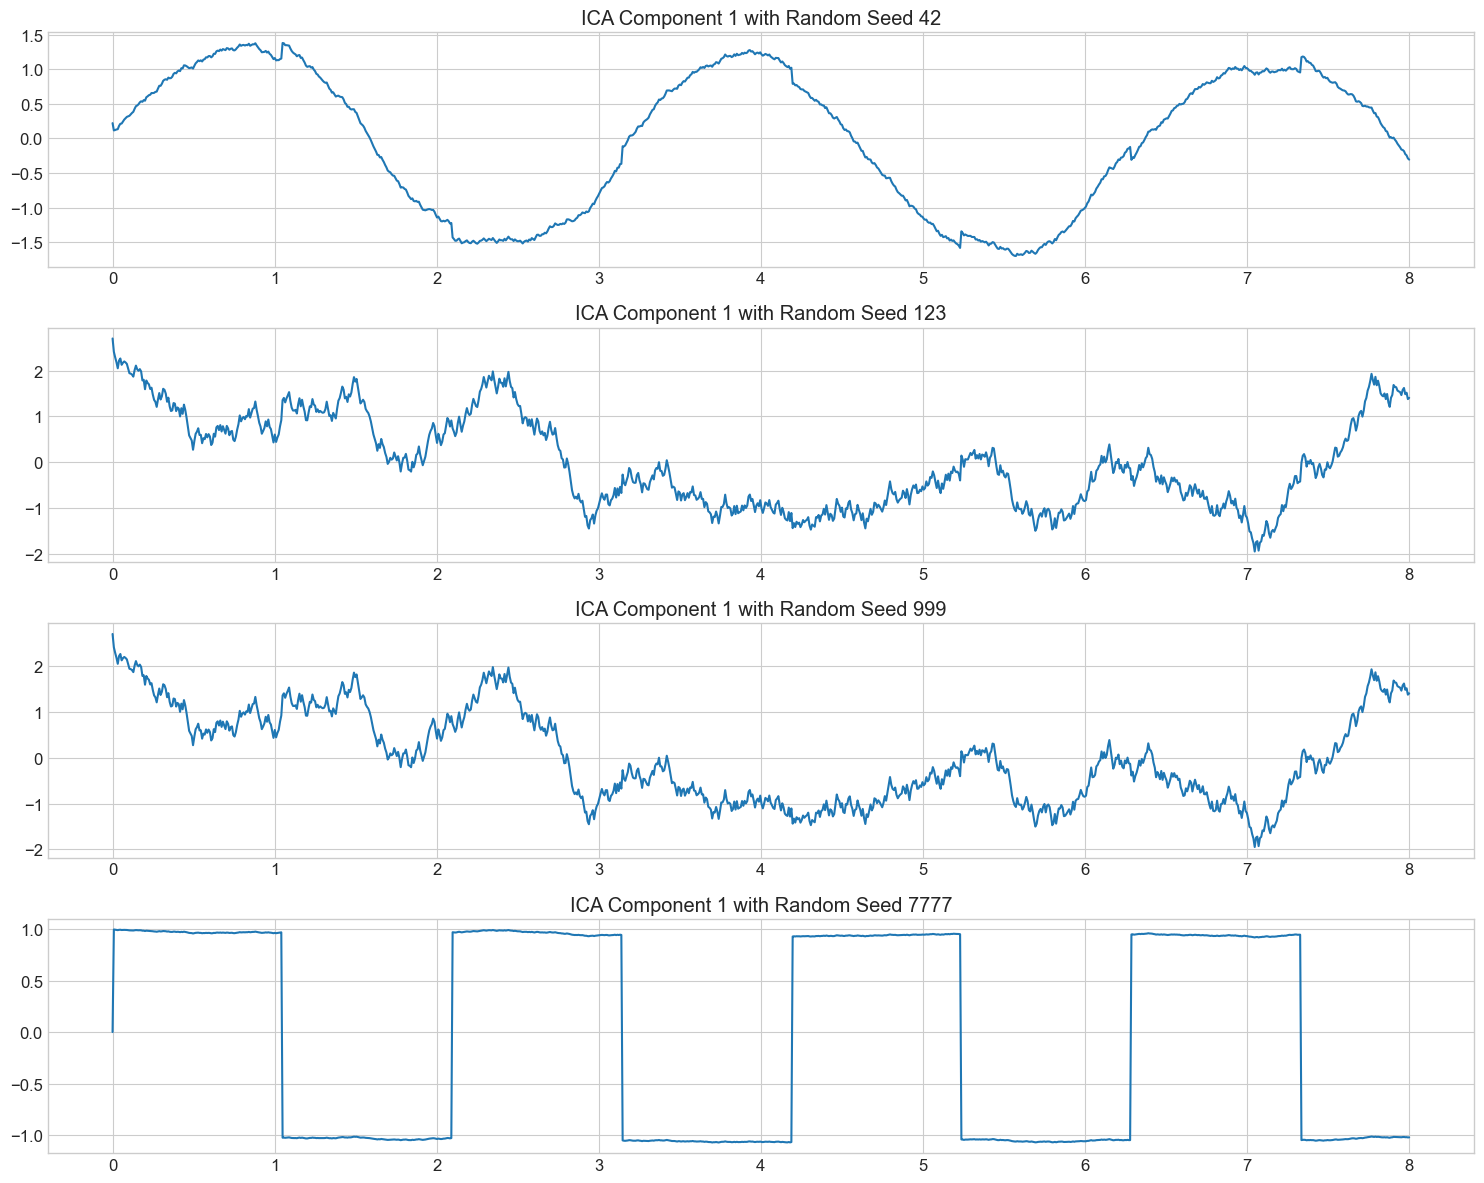

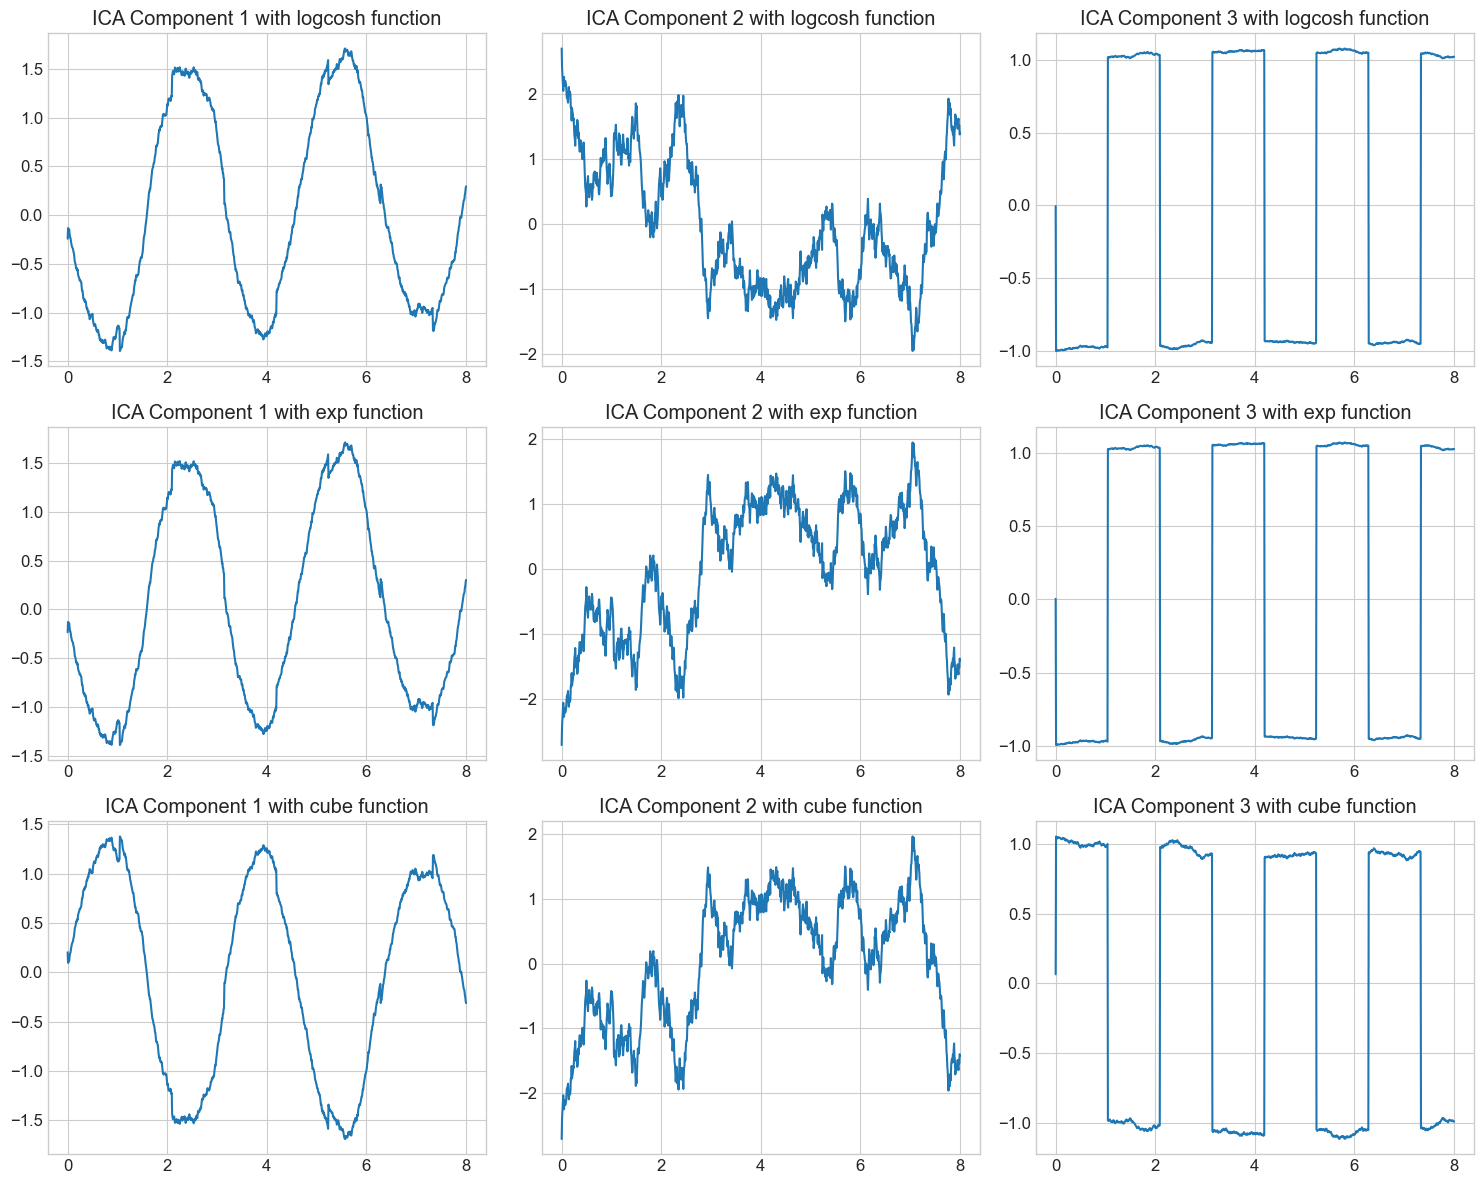

Component Similarity (Absolute Correlation) Between Different Random Seeds:

Similarity with seed 123:
[[5.8e-03 1.0e+00 2.0e-04]
 [1.0e+00 5.8e-03 1.0e-04]
 [1.0e-04 2.0e-04 1.0e+00]]

Similarity with seed 999:
[[3.5e-03 6.0e-04 1.0e+00]
 [1.0e+00 2.0e-04 3.5e-03]
 [2.0e-04 1.0e+00 6.0e-04]]

Similarity with seed 7777:
[[3.0e-03 3.1e-03 1.0e+00]
 [6.0e-04 1.0e+00 3.1e-03]
 [1.0e+00 6.0e-04 3.0e-03]]

Component Similarity Between Different Contrast Functions:

Similarity with exp function:
[[1.0e+00 1.4e-03 3.0e-04]
 [1.4e-03 1.0e+00 2.6e-03]
 [3.0e-04 2.6e-03 1.0e+00]]

Similarity with cube function:
[[1.     0.0059 0.0053]
 [0.006  0.9997 0.0224]
 [0.0052 0.0224 0.9997]]

Insights on ICA Sensitivity:
1. ICA results can vary significantly with different random initializations.
2. Different contrast functions may be better suited for different types of signals.
3. For robust analysis, it's recommended to run ICA multiple times and validate consistency.
4. The order of components can ch

In [70]:
# Generate synthetic mixed data for consistency
n_samples = 1000
time = np.linspace(0, 8, n_samples)

# Create three different source signals
s1 = np.sin(2 * time)  # Sine wave
s2 = np.sign(np.sin(3 * time))  # Square wave
s3 = np.random.uniform(-1, 1, size=time.shape)  # White noise
s3 = np.cumsum(s3) * 0.1  # Random walk

# Combine signals into a matrix
S = np.c_[s1, s2, s3]

# Create a mixing matrix
A = np.array([[0.5, 0.8, 0.2],
              [0.4, 0.3, 0.7],
              [0.8, 0.1, 0.5]])

# Mix the sources to create the observed signals
X = np.dot(S, A.T)

# Define different random seeds and contrast functions to test
random_seeds = [42, 123, 999, 7777]
contrast_functions = ['logcosh', 'exp', 'cube']

# Run ICA with different random seeds
plt.figure(figsize=(15, 12))
for i, seed in enumerate(random_seeds):
    ica_pipe = make_pipeline(StandardScaler(), FastICA(n_components=3, random_state=seed, max_iter=1000))
    S_ica = ica_pipe.fit_transform(X)
    
    # Plot the first component for each seed
    plt.subplot(len(random_seeds), 1, i+1)
    plt.plot(time, S_ica[:, 0])
    plt.title(f'ICA Component 1 with Random Seed {seed}')
    plt.grid(True)
    
plt.tight_layout()
plt.show()

# Run ICA with different contrast functions
plt.figure(figsize=(15, 12))
for i, func in enumerate(contrast_functions):
    ica_pipe = make_pipeline(StandardScaler(), FastICA(n_components=3, random_state=random_state, fun=func, max_iter=1000))
    S_ica = ica_pipe.fit_transform(X)
    
    # Plot all three components for each contrast function
    for j in range(3):
        plt.subplot(len(contrast_functions), 3, i*3 + j + 1)
        plt.plot(time, S_ica[:, j])
        plt.title(f'ICA Component {j+1} with {func} function')
        plt.grid(True)
    
plt.tight_layout()
plt.show()

# Quantify differences between runs
def compute_component_similarity(pipe1, pipe2, X):
    # Transform the data with both ICA pipelines
    S1 = pipe1.transform(X)
    S2 = pipe2.transform(X)
    
    # Calculate correlation between all pairs of components
    n_components = S1.shape[1]
    corr_matrix = np.zeros((n_components, n_components))
    
    for i in range(n_components):
        for j in range(n_components):
            # Use absolute correlation (sign doesn't matter in ICA)
            corr_matrix[i, j] = np.abs(np.corrcoef(S1[:, i], S2[:, j])[0, 1])
    
    return corr_matrix

# Initialize reference ICA
reference_ica = make_pipeline(StandardScaler(), FastICA(n_components=3, random_state=42, max_iter=1000))
reference_ica.fit(X)

# Compare with other seeds
print("Component Similarity (Absolute Correlation) Between Different Random Seeds:")
for seed in random_seeds[1:]:  # Skip the reference seed
    comparison_ica = make_pipeline(StandardScaler(), FastICA(n_components=3, random_state=seed, max_iter=1000))
    comparison_ica.fit(X)
    
    similarity = compute_component_similarity(reference_ica, comparison_ica, X)
    print(f"\nSimilarity with seed {seed}:")
    print(np.round(similarity, 4))

# Compare with different contrast functions
print("\nComponent Similarity Between Different Contrast Functions:")
for func in contrast_functions[1:]:  # Skip the reference function
    comparison_ica = make_pipeline(StandardScaler(), FastICA(n_components=3, random_state=42, fun=func, max_iter=1000))
    comparison_ica.fit(X)
    
    similarity = compute_component_similarity(reference_ica, comparison_ica, X)
    print(f"\nSimilarity with {func} function:")
    print(np.round(similarity, 4))

print("\nInsights on ICA Sensitivity:")
print("1. ICA results can vary significantly with different random initializations.")
print("2. Different contrast functions may be better suited for different types of signals.")
print("3. For robust analysis, it's recommended to run ICA multiple times and validate consistency.")
print("4. The order of components can change between runs, so matching them by correlation is necessary.")

## Conclusion

This notebook has demonstrated various practical applications of PCA and ICA through illustrative examples. Key takeaways include:

1. **PCA focuses on variance maximization** and produces orthogonal components that are uncorrelated but not necessarily independent.
2. **ICA aims to identify statistically independent sources** and performs best with non-Gaussian signals.
3. Both methods are valuable for different tasks:
   - PCA excels at dimension reduction and capturing dominant patterns.
   - ICA is superior for source separation and identifying distinct, meaningful components.
4. In event studies, component analysis can reveal aspects of the temporal patterns around events.
5. ICA is more sensitive to initialization and parameter choices, requiring careful validation.

Understanding the strengths and limitations of each method allows us to choose the appropriate technique based on the specific problem and data characteristics.